In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items'), # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:\\Users\\fasil\\OneDrive\\Desktop\\Projects\\Target'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Warning: File {csv_file} not found at {file_path}. Skipping.")
        continue
    
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Replace NaN with None to handle SQL NULL
        df = df.where(pd.notnull(df), None)
        
        # Debugging: Check for NaN values
        print(f"Processing {csv_file}")
        print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

        # Clean column names
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Generate the CREATE TABLE statement with appropriate data types
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Insert DataFrame data into the MySQL table
        for _, row in df.iterrows():
            # Convert row to tuple and handle NaN/None explicitly
            values = tuple(None if pd.isna(x) else x for x in row)
            sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
            cursor.execute(sql, values)

        # Commit the transaction for the current CSV file
        conn.commit()
    
    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")
        continue

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host= "localhost", username = "root", password = "12345", database = "ecommerce")
cur =  db.cursor()

## DATA PREPROCESSING

In [4]:
null_values = df.isnull().sum()
print(null_values)

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


In [9]:
duplicates = df.duplicated()
print(df[duplicates])
print(f'Number of duplicate rows: {duplicates.sum()}')

Empty DataFrame
Columns: [order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value]
Index: []
Number of duplicate rows: 0


## List all unique cities where customers are located.

In [5]:
query = "select distinct(customer_city) from customers"
cur.execute(query)
data =  cur.fetchall()
for city in data:
    print(city[0])

franca
sao bernardo do campo
sao paulo
mogi das cruzes
campinas
jaragua do sul
timoteo
curitiba
belo horizonte
montes claros
rio de janeiro
lencois paulista
caxias do sul
piracicaba
guarulhos
pacaja
florianopolis
aparecida de goiania
santo andre
goiania
cachoeiro de itapemirim
sao jose dos campos
sao roque
camacari
resende
sumare
novo hamburgo
sao luis
sao jose
santa barbara
ribeirao preto
ituiutaba
taquarituba
sao jose dos pinhais
barrinha
parati
dourados
trindade
cascavel
fortaleza
brasilia
pelotas
porto alegre
salto
jundiai
cacapava
sao vicente
uberlandia
botelhos
sao goncalo
araucaria
nova iguacu
areia branca
campos dos goytacazes
sao carlos
itajuba
cruz das almas
vassouras
feira de santana
niteroi
sobral
divinopolis
paraiba do sul
paulista
carapicuiba
bom principio
astolfo dutra
marialva
sao jose do rio preto
cabo frio
contagem
cafeara
sao joaquim da barra
foz do iguacu
suzano
timbo
camboriu
nova bassano
rio grande
braganca paulista
barra do garcas
embu
urussanga
silvianopolis
gam

## Count the number of orders placed in 2017.

In [10]:
 query = "select count(order_id) from orders where year(order_purchase_timestamp) = 2017"
cur.execute(query)
data =  cur.fetchall()
data[0][0]

90202

### Find the total sales per category.

In [18]:
query = """ SELECT UPPER(products.product_category) AS category,
       ROUND(SUM(order_items.price), 2) AS sales
FROM products
JOIN order_items
    ON products.product_id = order_items.product_id
JOIN payments
    ON payments.order_id = order_items.order_id
GROUP BY category;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,3302038.47
1,FURNITURE DECORATION,6120751.14
2,TELEPHONY,2715193.27
3,BED TABLE BATH,8740408.16
4,AUTOMOTIVE,4934020.09
...,...,...
69,CDS MUSIC DVDS,5840.00
70,LA CUISINE,18431.84
71,FASHION CHILDREN'S CLOTHING,4558.80
72,PC GAMER,13407.52


## Calculate the percentage of orders that were paid in installments

In [19]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## Count the number of customers from each state. 

C:\Users\fasil\AppData\Local\Temp\ipykernel_14540\2693918482.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df["state"], y=df["customer_count"], palette="viridis")
C:\Users\fasil\anaconda4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127758 (\N{EARTH GLOBE AMERICAS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


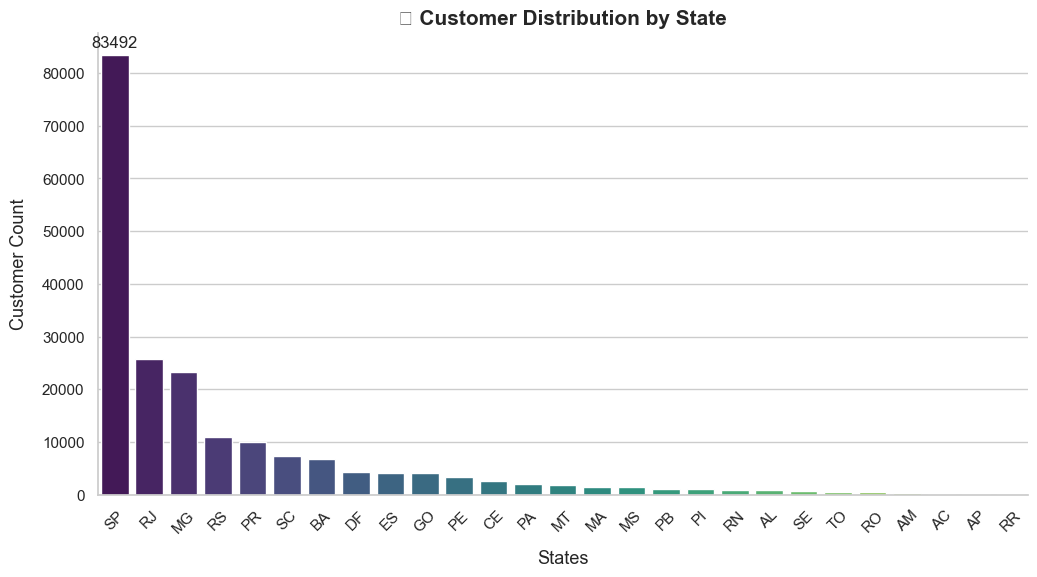

In [28]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""
sns.set_theme(style="whitegrid")

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["state", "customer_count"])
df = df.sort_values(by="customer_count", ascending=False)
plt.figure(figsize=(12, 6))

ax = sns.barplot(x=df["state"], y=df["customer_count"], palette="viridis")

plt.xticks(rotation=45, fontsize=11)

ax.bar_label(ax.containers[0], fmt="%d", fontsize=12, padding=3)

plt.xlabel("States", fontsize=13, labelpad=10)
plt.ylabel("Customer Count", fontsize=13, labelpad=10)
plt.title("🌎 Customer Distribution by State", fontsize=15, fontweight="bold")
sns.despine()
plt.show()

C:\Users\fasil\AppData\Local\Temp\ipykernel_14540\1489171370.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df["months"], y=df["order_count"], data=df,
C:\Users\fasil\anaconda4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


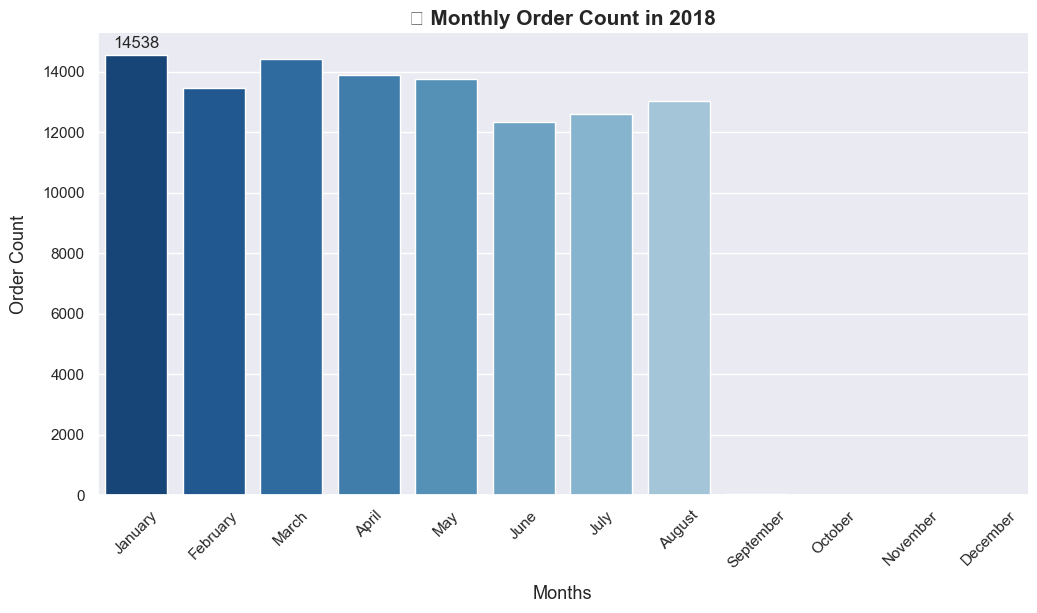

In [27]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

sns.set_theme(style="darkgrid")

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["months", "order_count"])

o = ["January", "February", "March", "April", "May", "June", "July", 
     "August", "September", "October", "November", "December"]

plt.figure(figsize=(12, 6))

ax = sns.barplot(x=df["months"], y=df["order_count"], data=df, 
                 order=o, palette="Blues_r")  # Try "coolwarm", "viridis" too

plt.xticks(rotation=45, fontsize=11)

ax.bar_label(ax.containers[0], fmt="%d", fontsize=12, padding=3)

plt.xlabel("Months", fontsize=13, labelpad=10)
plt.ylabel("Order Count", fontsize=13, labelpad=10)
plt.title("📊 Monthly Order Count in 2018", fontsize=15, fontweight="bold")

sns.despine()
plt.show()

## Find the average number of products per order, grouped by customer city.

In [29]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


## Calculate the percentage of total revenue contributed by each product category

In [31]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


## Identify the correlation between product price and the number of times a product has been purchased.

In [33]:
import numpy as np
import pandas as pd

cur = db.cursor()

# SQL Query to get product category, order count, and average price
query = """SELECT products.product_category, 
                  COUNT(order_items.product_id) AS order_count,
                  ROUND(AVG(order_items.price), 2) AS avg_price
           FROM products 
           JOIN order_items ON products.product_id = order_items.product_id
           GROUP BY products.product_category"""

# Execute query and fetch data
cur.execute(query)
data = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Category", "order_count", "price"])

# Ensure numeric values and remove NaNs
arr1 = df["order_count"].astype(float).dropna()
arr2 = df["price"].astype(float).dropna()

# Calculate correlation correctly
correlation = np.corrcoef(arr1, arr2)[0, 1]

# Print result
print("📊 The correlation between order count and price is:", round(correlation, 2))

📊 The correlation between order count and price is: -0.11


## Calculate the total revenue generated by each seller, and rank them by revenue.


C:\Users\fasil\AppData\Local\Temp\ipykernel_14540\4147555993.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="revenue", y="seller_id", data=df, palette="coolwarm")
C:\Users\fasil\anaconda4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


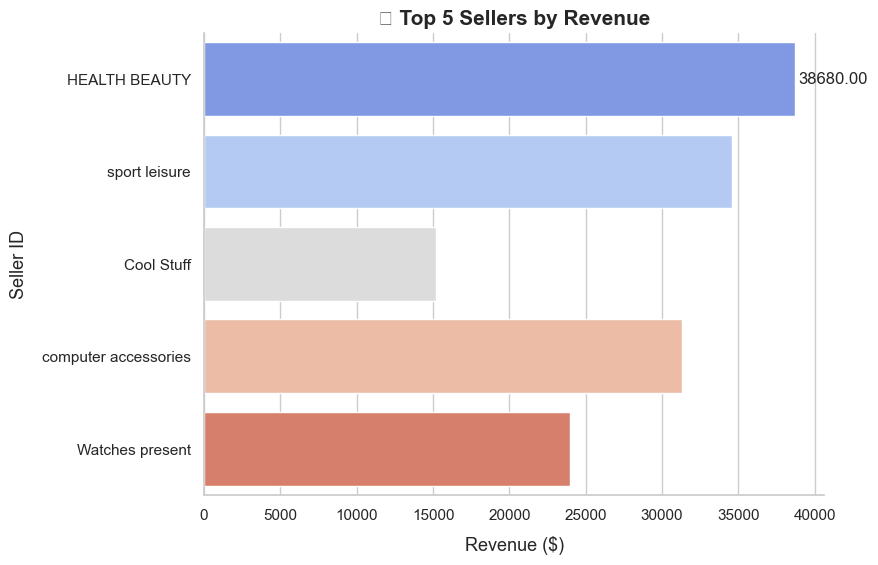

In [34]:
cur.execute(query)
data = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])

# Keep only top 5 sellers
df = df.head()

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create figure with larger size
plt.figure(figsize=(8, 6))

# Plot horizontal bar chart with better colors
ax = sns.barplot(x="revenue", y="seller_id", data=df, palette="coolwarm")

# Add data labels on the bars
ax.bar_label(ax.containers[0], fmt="%.2f", fontsize=12, padding=3)

# Add titles and labels
plt.xlabel("Revenue ($)", fontsize=13, labelpad=10)
plt.ylabel("Seller ID", fontsize=13, labelpad=10)
plt.title("🏆 Top 5 Sellers by Revenue", fontsize=15, fontweight="bold")

# Remove top & right borders
sns.despine()

# Show plot
plt.show()

## Calculate the moving average of order values for each customer over their order history.

In [48]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


##  Calculate the cumulative sales per month for each year.

In [49]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


## Calculate the year-over-year growth rate of total sales

In [50]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [51]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

## Identify the top 3 customers who spent the most money in each year.

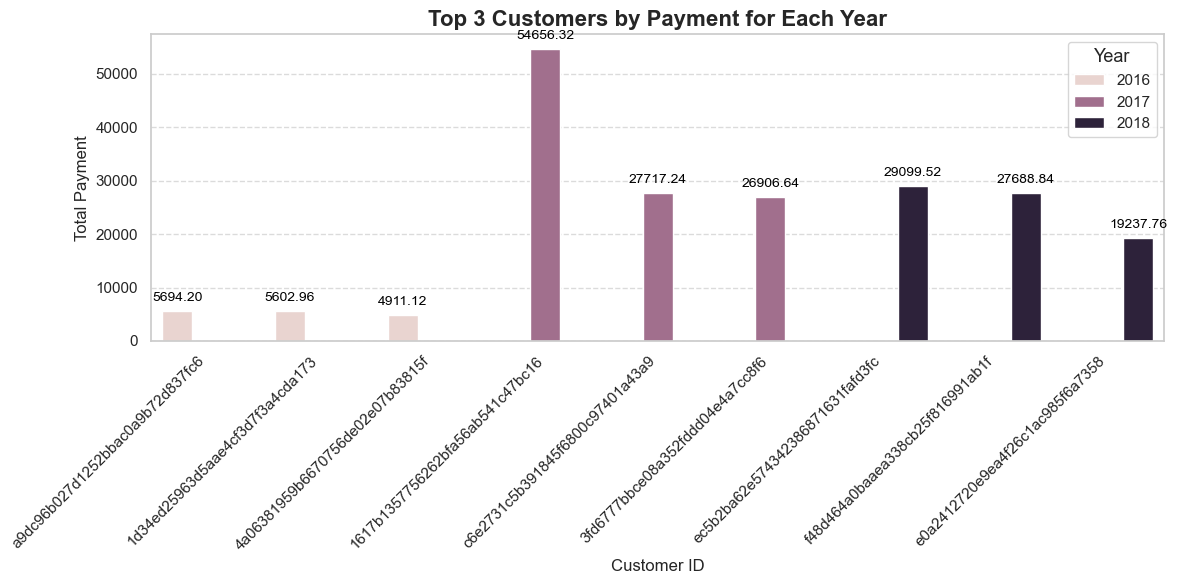

In [55]:
db = mysql.connector.connect(
    host="localhost", 
    user="root", 
    password="12345", 
    database="ecommerce"
)

cur = db.cursor()
query = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
           orders.customer_id,
           SUM(payments.payment_value) AS payment,
           DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp) 
                              ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a
WHERE d_rank <= 3;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])
cur.close()
db.close()
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="id", y="payment", data=df, hue="years", dodge=True)
plt.title("Top 3 Customers by Payment for Each Year", fontsize=16, fontweight="bold")
plt.xlabel("Customer ID", fontsize=12)
plt.ylabel("Total Payment", fontsize=12)
plt.xticks(rotation=45, ha="right")
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=10, color='black', padding=5)
plt.legend(title="Year", title_fontsize='13', fontsize='11')

# Add gridlines for a cleaner look
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
